In [1]:
# Data wranggling
import numpy as np
import pandas as pd

# Machine learning management
import mlflow
from mlflow.models.signature import infer_signature

# Visualização de dados
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipelines para tratar dados futuros
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para  incluir no pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Manter a saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
# Definição de função para mostrar as métricas do nosso modelo
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'R2': metrics.r2_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    }
    return dict_metrics

In [3]:
# Carregar a base
df = pd.read_csv('../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Modeling

In [4]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICALA_FEATURES = ['smoker']

FEATURES = NUMERICAL_FEATURES + CATEGORICALA_FEATURES
TARGET = 'charges'

In [5]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [6]:
# Fazer a pipeline
numerical_transfomer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # aqui estamos colocando nos valores faltantes a média
    ('scaler', MinMaxScaler()) # Padronização
])

categorical_transfomer = OneHotEncoder(drop='if_binary', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transfomer, NUMERICAL_FEATURES),
    ('cat', categorical_transfomer, CATEGORICALA_FEATURES)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'bmi', 'children']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['smoker'])])

In [7]:
preprocessor.fit_transform(X_train)

,num__age,num__bmi,num__children,cat__smoker_yes
1068,0.978261,0.153349,0.2,0.0
1018,0.782609,0.534167,0.6,0.0
995,0.456522,0.196798,0.6,0.0
1248,0.000000,0.641916,0.0,0.0
549,0.543478,0.813559,0.0,1.0
...,...,...,...,...
884,0.152174,0.288808,0.8,0.0
515,0.869565,0.531073,0.0,0.0
695,0.173913,0.651735,0.0,0.0
454,0.304348,0.822437,0.4,0.0


In [8]:
preprocessor.transform(X_test)

,num__age,num__bmi,num__children,cat__smoker_yes
748,0.630435,0.539144,0.2,0.0
745,0.695652,0.380818,0.2,0.0
57,0.000000,0.422922,0.4,1.0
546,0.217391,0.523944,0.0,0.0
279,0.717391,0.150659,0.2,0.0
...,...,...,...,...
681,0.021739,0.116761,0.0,0.0
340,0.130435,0.313156,0.0,0.0
1199,0.282609,0.264730,0.4,0.0
61,0.152174,0.476190,0.8,0.0


In [9]:
# Especificando modelos que vamos usar
models = {
    'Dummy': DummyRegressor(),
    'LinearRegression': LinearRegression(),
    'LassoCV': LassoCV(),
    'RidgeCV': RidgeCV(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

In [10]:
# Agora com o MLflow vamos setar um experimento
mlflow.search_experiments('Insurance')

[]

/home/faust/Projetos/DNC/Mes-06/mlflow-project/.venv/lib/python3.8/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/home/faust/Projetos/DNC/Mes-06/mlflow-project/.venv/lib/python3.8/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Set

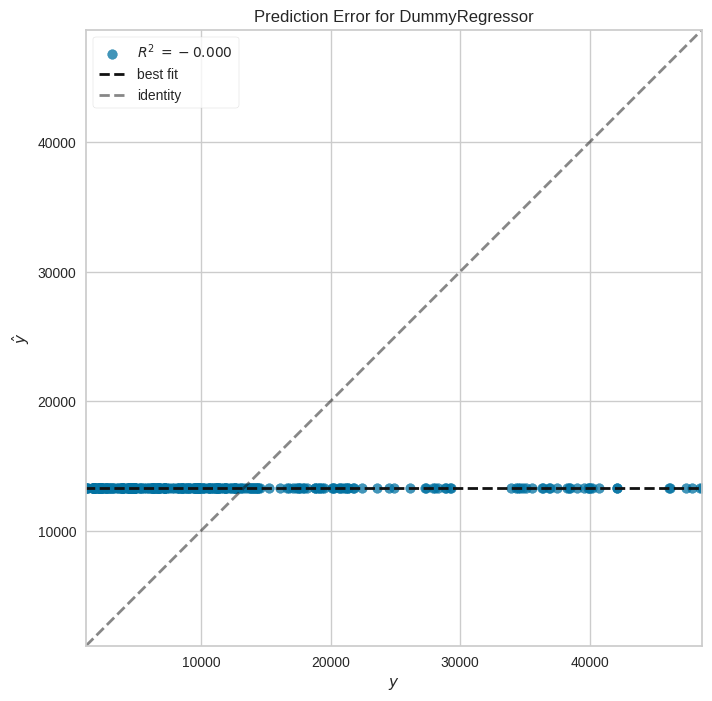

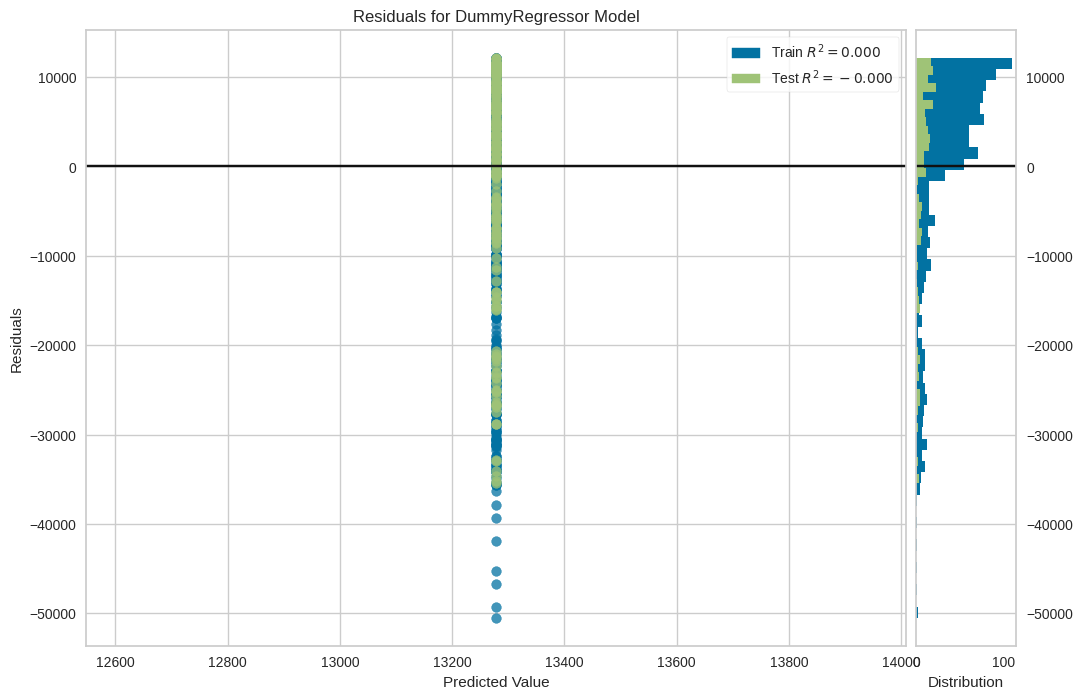

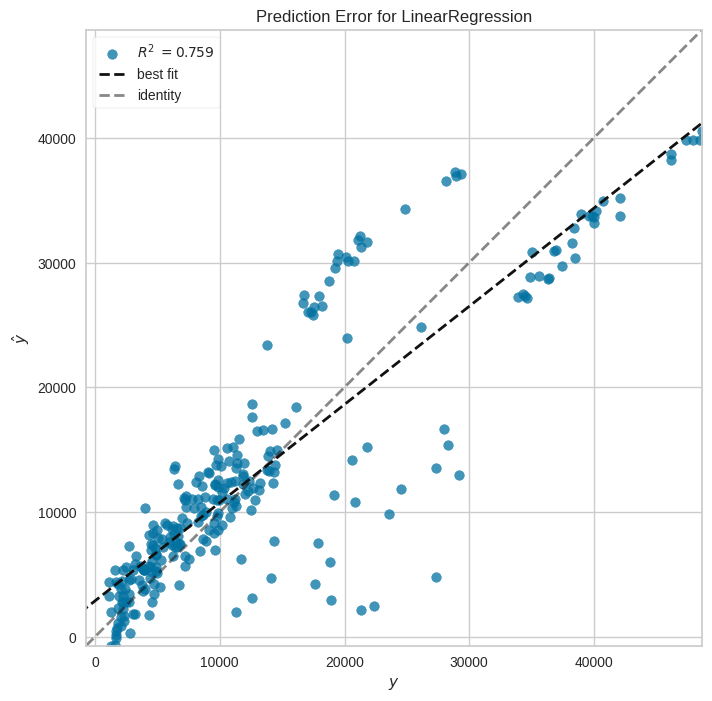

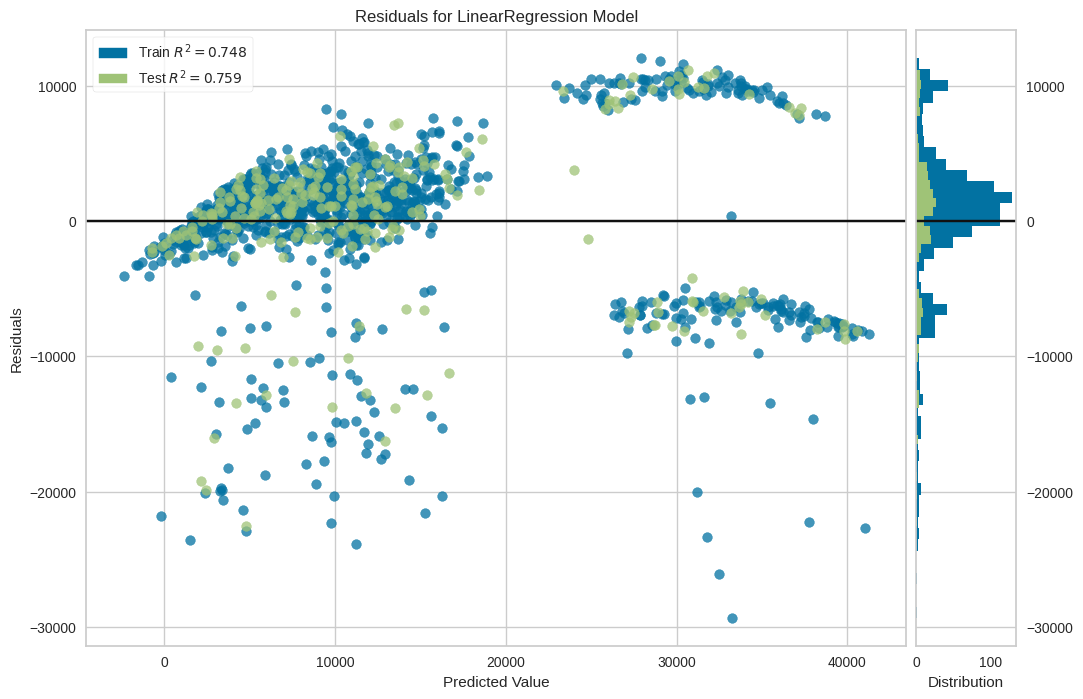

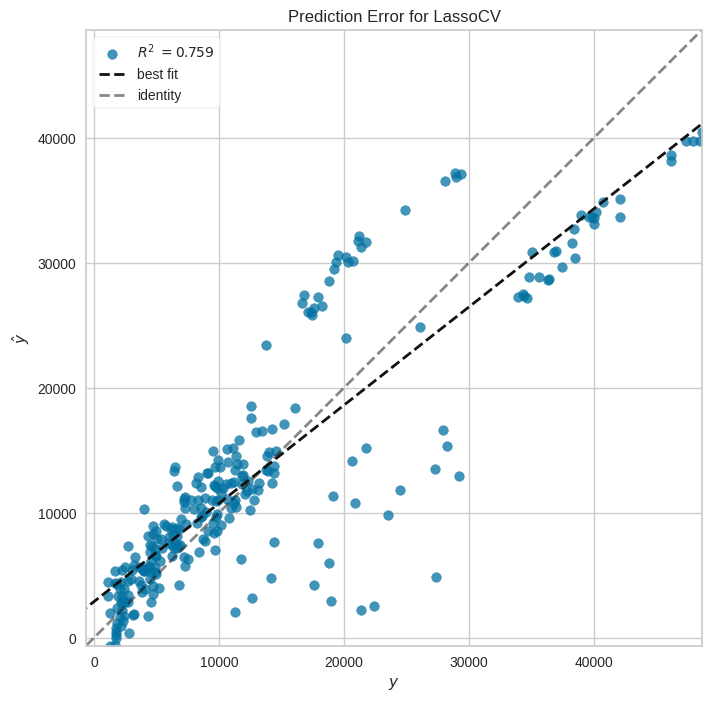

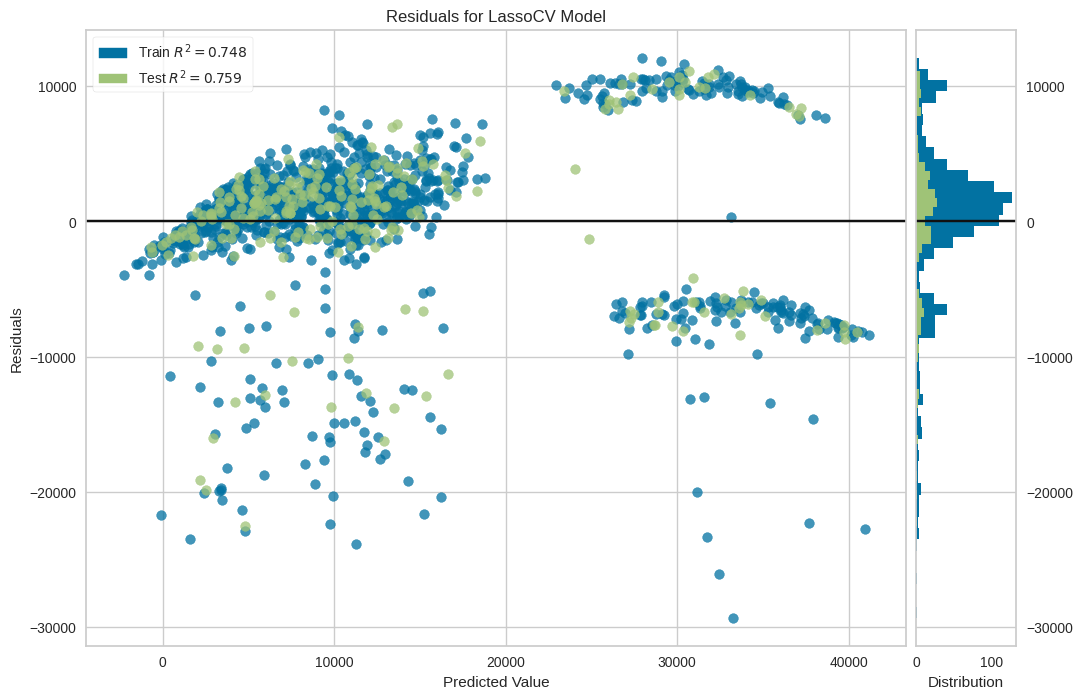

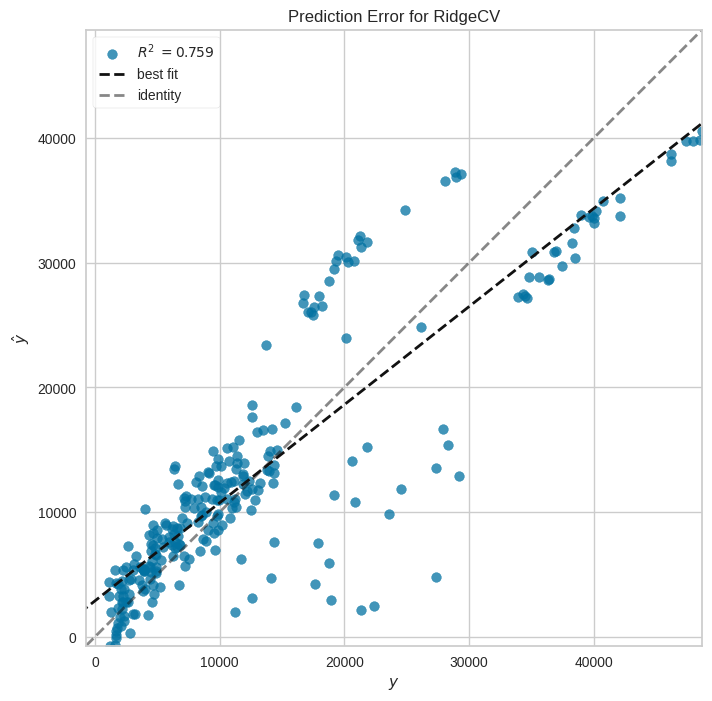

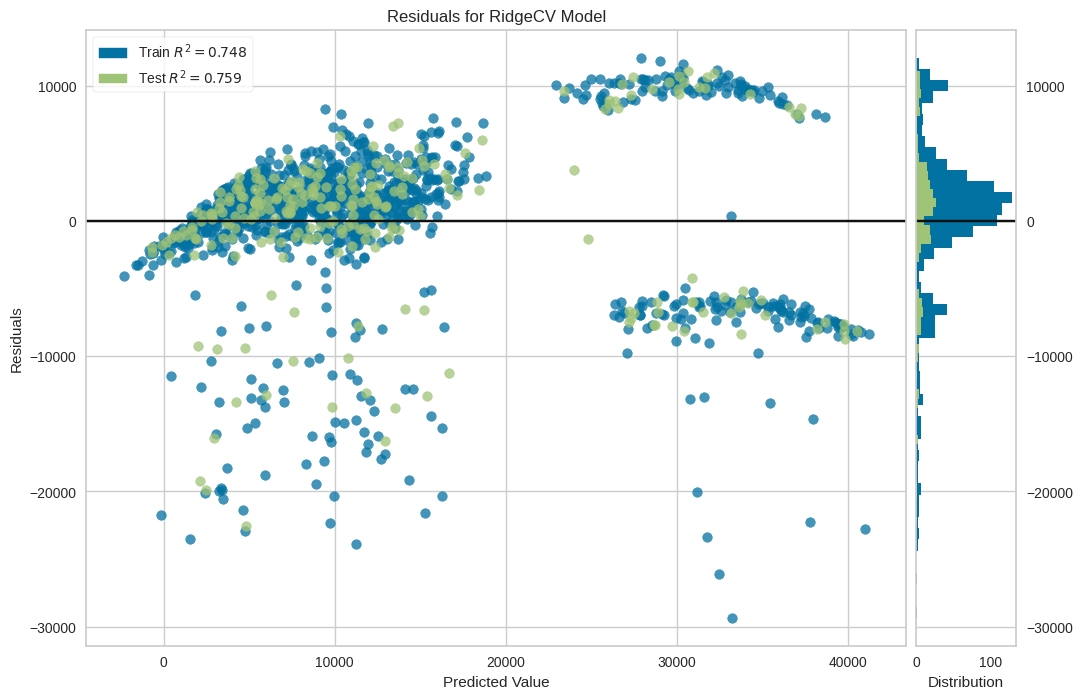

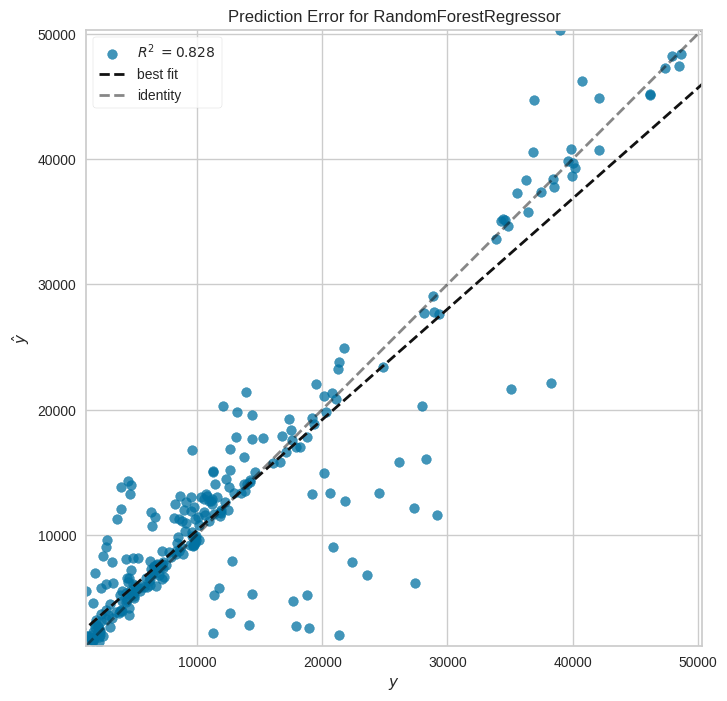

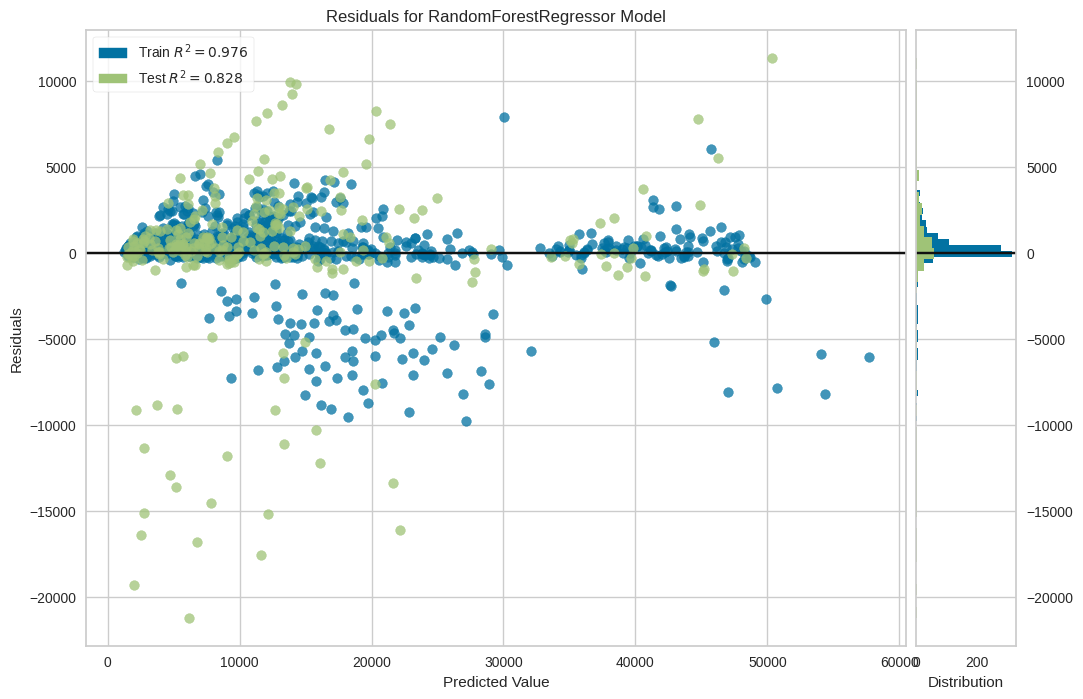

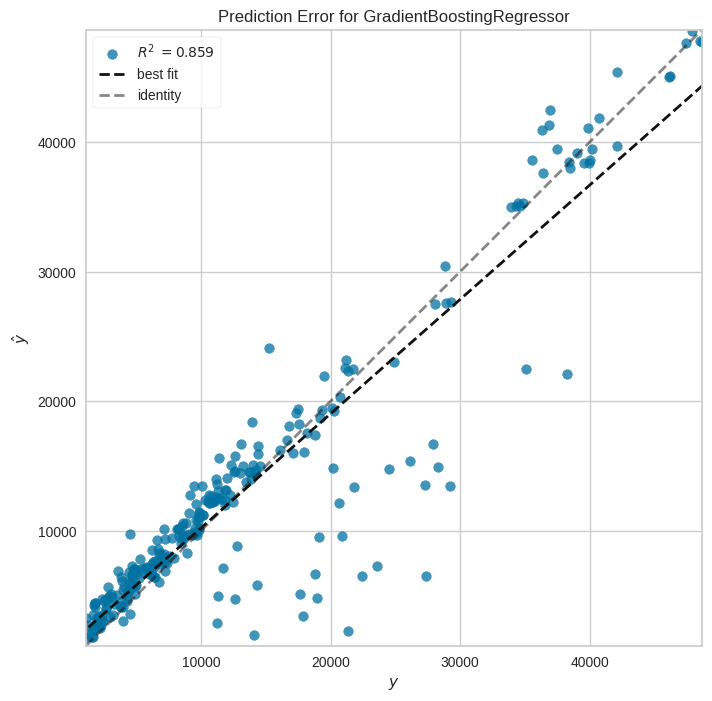

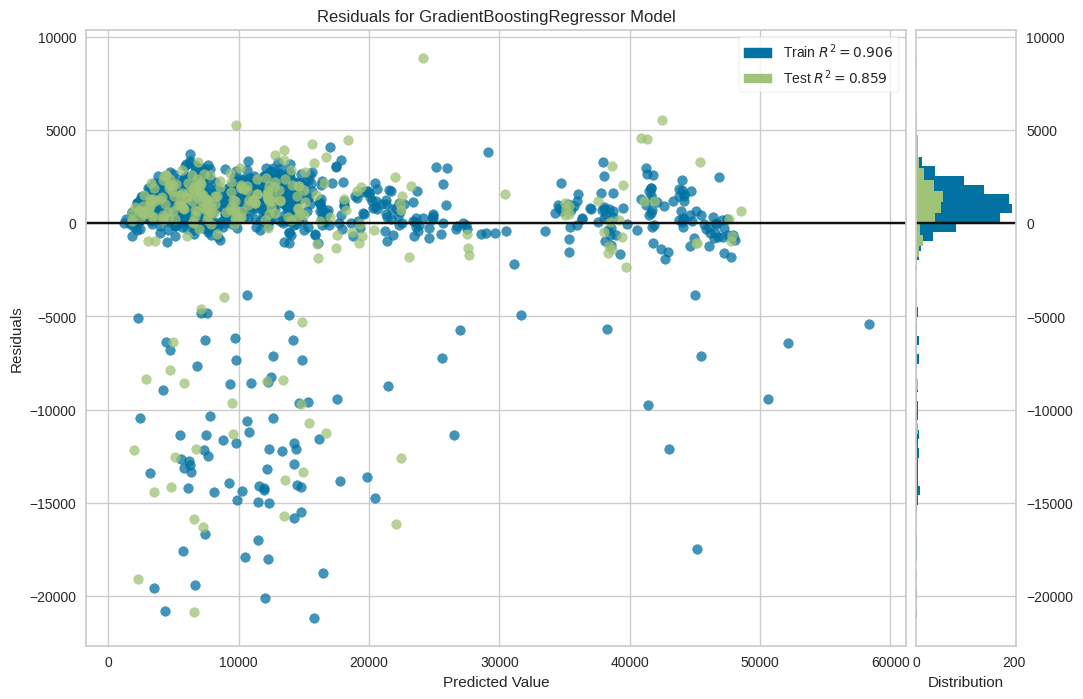

In [11]:
# Como queremos salvar vários modelos no MLflow, vamos fazer um loop
for model_name, model in models.items():

    # Model pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Treiar modelo
    model_pipeline.fit(X_train, y_train)
    # Pegar predições
    y_pred = model_pipeline.predict(X_test)
    model_metrics = get_metrics(y_test, y_pred)
    # Pegar parâmetros do modelo
    model_params = model_pipeline.named_steps['model'].get_params()

    # MLFlow
    with mlflow.start_run():
        # Log métricas do modelo
        mlflow.log_metrics(model_metrics)
        # Log hiperparâmetros do modelo
        mlflow.log_params(model_params)

        # Log figuras
        fig,ax = plt.subplots(figsize=(12,8))
        prediction_error(model_pipeline, X_train, y_train, X_test, y_test, show=False, ax=ax)
        mlflow.log_figure(fig, artifact_file='plots/prediction_error.png')
        fig,ax = plt.subplots(figsize=(12,8))
        residuals_plot(model_pipeline, X_train, y_train, X_test, y_test, show=False, ax=ax)
        mlflow.log_figure(fig, artifact_file='plots/residuals_plot.png')

        # Log do modelo
        signature = infer_signature(X_test, model_pipeline.predict(X_test))
        mlflow.sklearn.log_model(model_pipeline, 'model_pipeline', registered_model_name=model_name, signature=signature)


## Tunagem modelo

In [13]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['smoker'])])),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [300, 400, 500],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=1)

In [17]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:, ~df_cv_results.columns.str.contains('split|time')].head(10)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858604,0.005619
2,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858137,0.005719
3,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857373,0.006668
4,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857343,0.006405
5,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.857141,0.004968
6,0.01,3,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.856103,0.006204
7,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854234,0.006895
8,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854206,0.006554
9,0.01,4,300,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.854169,0.005887
